# Port-au-Prince Input Data Analysis 

### Authors: Carter Murphy, Nick Bourgeois, Mackenzie Kummer, Nolan Penoyer

## Importing Packages

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.sandbox.stats.runs import runstest_1samp
from datetime import *

## Reading the Data

In [95]:
aircraft_capabilities = pd.read_excel("AircraftCapabilities.xlsx")
aircraft_capabilities.columns = ['Aircraft Type','Capacity (sTon)','Avg Load (sTon)']
aircraft_capabilities.head()

,Aircraft Type,Capacity (sTon),Avg Load (sTon)
0,707,26.0,20.28
1,727,13.0,10.14
2,737,11.0,8.58
3,747,78.0,60.84
4,767,58.0,45.24


### Aircraft Capacity Histogram

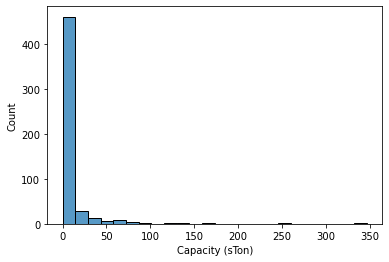

In [96]:
sns.histplot(data=aircraft_capabilities,x='Capacity (sTon)',bins=math.ceil(math.sqrt(len(aircraft_capabilities))))
plt.show()

### Aircraft Average Load Histogram

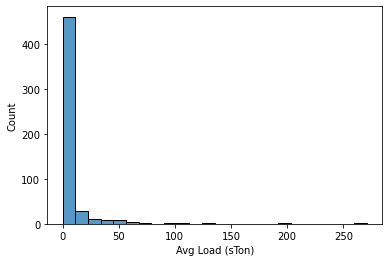

In [97]:
sns.histplot(data=aircraft_capabilities,x='Avg Load (sTon)',bins=math.ceil(math.sqrt(len(aircraft_capabilities))))
plt.show()

### Goes through all aircraft types, then lists the capacity (in tons) of each type of aircraft and the average load of each type of aircraft. From the histograms plotted, it is evident that most planes carry a smaller load of around 0-50 tons of cargo. Therefore we have deemed it unneccessary to try and split up this data based on the type of aircraft (GOV, NGO, and MIL aircraft).

In [98]:
ground_time = pd.read_excel("GroundTime.xlsx")
ground_time = ground_time.drop(ground_time.columns[[2,3]], axis=1)
ground_time.columns = ['Ground Time (Hrs)', 'ID']
ground_time.head()

,Ground Time (Hrs),ID
0,1.872,2706
1,0.748,2707
2,1.454,2708
3,1.178,2709
4,1.202,2710


### Lists an ID for each plane that can also be found in HFOCC data, and pairs the ground time (in hours) for every aircraft. Each ground time observation can be understood as the time from landing at the Port-au-Prince airport to leaving the airport. The ground time is measured in hours. 

In [99]:
hfocc = pd.read_excel("HFOCC.xlsx")
hfocc.head()

,Request Status,Arrival Date,Arrival Time,Organization,Aircraft Type,Call Sign,Tail #,A/C Size,Affiliation,Request ID,...,Nationality,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created
0,Complete,2010-01-12,2100Z,DSWA LLC,LEARJET,N4009,N4009,N,NGO,TBD,...,UNITED STATES,MEDICAL SUPPLIES/MEDICAL PAX,UNK,NaN,NaN,JJ,NaN,2706,2010-02-06 15:22:56,2010-02-03 09:08:54
1,Complete,2010-01-15,1900Z,DOD,UNKNOWN,PAT141,Unknown,S,MIL,TBD,...,UNITED STATES,GA ARMY GUARD PAX & CARGO,2,NaN,NaN,NaN,NaN,2707,2010-02-11 10:36:54,2010-02-03 09:08:54
2,Complete,2010-01-16,0400Z,US SENATOR,GULFSTREAM,N450GD,N450GD,N,GOV,125,...,UNITED STATES,PICK UP EVACUEES,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54
3,Complete,2010-01-16,0900Z,DoD (612),UNKNOWN,SHARK94,Unknown,N,MIL,F319,...,UNITED STATES,CARGO OUT/AM DIV SHUTTLE,UNK,NaN,NaN,NaN,NaN,2709,2010-02-07 08:20:31,2010-02-03 09:08:54
4,Complete,2010-01-16,1000Z,1 SOW,C130,RCH1031,UNKNOWN,N,MIL,159,...,UNITED STATES,MEDICAL SUPPLIES,5,NaN,NaN,NaN,NaN,2710,2010-02-11 13:24:41,2010-02-03 09:08:54


### Lots of unnecessary data, lets us know the Id of plane and the size of each plane. Also tells us the arrival time and arrival date. Also whether the plane actually arrived 

In [100]:
data = [['13 Jan-28 Jan',390,290,250,700],['29 Jan-28 Feb',195,145,125,200]]
daily_demand = pd.DataFrame(data,columns=['Dates','Water','Food','Medical','Logistics'])
daily_demand

,Dates,Water,Food,Medical,Logistics
0,13 Jan-28 Jan,390,290,250,700
1,29 Jan-28 Feb,195,145,125,200


### Lists the average daily demand (in tons) of water, food, medical supplies, and logistics over the specified dates

## Merging the HFOCC and Ground Time data

In [101]:
hfocc2 = ground_time.merge(hfocc, on='ID', how='inner')
hfocc2.head()

,Ground Time (Hrs),ID,Request Status,Arrival Date,Arrival Time,Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,Chg,Nationality,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,Modified,Created
0,1.872,2706,Complete,2010-01-12,2100Z,DSWA LLC,LEARJET,N4009,N4009,N,...,0.0,UNITED STATES,MEDICAL SUPPLIES/MEDICAL PAX,UNK,NaN,NaN,JJ,NaN,2010-02-06 15:22:56,2010-02-03 09:08:54
1,0.748,2707,Complete,2010-01-15,1900Z,DOD,UNKNOWN,PAT141,Unknown,S,...,0.0,UNITED STATES,GA ARMY GUARD PAX & CARGO,2,NaN,NaN,NaN,NaN,2010-02-11 10:36:54,2010-02-03 09:08:54
2,1.454,2708,Complete,2010-01-16,0400Z,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,0.0,UNITED STATES,PICK UP EVACUEES,14,NaN,NaN,NaN,NaN,2010-02-06 15:01:10,2010-02-03 09:08:54
3,1.178,2709,Complete,2010-01-16,0900Z,DoD (612),UNKNOWN,SHARK94,Unknown,N,...,0.0,UNITED STATES,CARGO OUT/AM DIV SHUTTLE,UNK,NaN,NaN,NaN,NaN,2010-02-07 08:20:31,2010-02-03 09:08:54
4,1.202,2710,Complete,2010-01-16,1000Z,1 SOW,C130,RCH1031,UNKNOWN,N,...,0.0,UNITED STATES,MEDICAL SUPPLIES,5,NaN,NaN,NaN,NaN,2010-02-11 13:24:41,2010-02-03 09:08:54


### Now that we have combined the HFOCC data with the ground time data to match the ID of each plane. We can split the new data set for the size of each plane (wide, narrow, and small aircraft).  

In [102]:
hfocc2_tidy = hfocc2[['Ground Time (Hrs)','ID','Request Status','Arrival Date','Arrival Time','Aircraft Type','A/C Size','CNX DATE','CNX TIME']]
hfocc2_tidy.head()

,Ground Time (Hrs),ID,Request Status,Arrival Date,Arrival Time,Aircraft Type,A/C Size,CNX DATE,CNX TIME
0,1.872,2706,Complete,2010-01-12,2100Z,LEARJET,N,NaN,NaN
1,0.748,2707,Complete,2010-01-15,1900Z,UNKNOWN,S,NaN,NaN
2,1.454,2708,Complete,2010-01-16,0400Z,GULFSTREAM,N,NaN,NaN
3,1.178,2709,Complete,2010-01-16,0900Z,UNKNOWN,N,NaN,NaN
4,1.202,2710,Complete,2010-01-16,1000Z,C130,N,NaN,NaN


In [103]:
hfocc2_tidy['Arrival Time'] = hfocc2_tidy['Arrival Time'].str.replace('Z','')
hfocc2_tidy.head()

C:\Users\C23NIC~1.BOU\AppData\Local\Temp/ipykernel_17084/2698084838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hfocc2_tidy['Arrival Time'] = hfocc2_tidy['Arrival Time'].str.replace('Z','')


,Ground Time (Hrs),ID,Request Status,Arrival Date,Arrival Time,Aircraft Type,A/C Size,CNX DATE,CNX TIME
0,1.872,2706,Complete,2010-01-12,2100,LEARJET,N,NaN,NaN
1,0.748,2707,Complete,2010-01-15,1900,UNKNOWN,S,NaN,NaN
2,1.454,2708,Complete,2010-01-16,0400,GULFSTREAM,N,NaN,NaN
3,1.178,2709,Complete,2010-01-16,0900,UNKNOWN,N,NaN,NaN
4,1.202,2710,Complete,2010-01-16,1000,C130,N,NaN,NaN


In [104]:
plane_narrow = hfocc2_tidy[hfocc2_tidy['A/C Size'] == 'N']

In [105]:
plane_wide = hfocc2_tidy[hfocc2_tidy['A/C Size'] == 'W']

In [106]:
plane_small = hfocc2_tidy[hfocc2_tidy['A/C Size'] == 'S']

### The new data set containing important arrival and ground time data has been split into three different dataframes. Each dataframe corresponds to the three different sizes of planes arriving into Port-au-Prince airport. We can now use each of these dataframes to inspect the homogeneity, stationarity, and independence of the ground time data for the different sizes of planes. 

## Analysis of Arrival Dates

### Converting the dates into integers 

In [107]:
new_dates = pd.read_excel("HFOCC Dates Converted.xlsx")
new_dates = new_dates.filter(["Date"])
new_dates.head()

,Date
0,0
1,3
2,4
3,4
4,4


In [108]:
new_dates2 = pd.read_excel("HFOCC_Dates_Converted.xlsx")
new_dates2 = new_dates2.filter(["Arrival Count"])
new_dates2 = new_dates2.iloc[0:49,:]
new_dates2

,Arrival Count
0,1.0
1,0.0
2,0.0
3,1.0
4,88.0
5,177.0
6,168.0
7,222.0
8,179.0
9,177.0


### Discrete vs. Continuous

#### The dates portion of the data is discrete because a date can not be split into multiple objects. Therefore one date reperesents one object, so the data is discrete and not continuous. 

### Check for Homogeneity

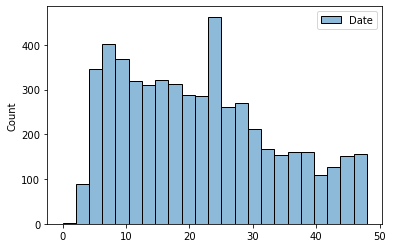

In [109]:
sns.histplot(new_dates)
plt.show()

#### Follows one distribution, therefore the data is homogenous

### Check for Stationarity

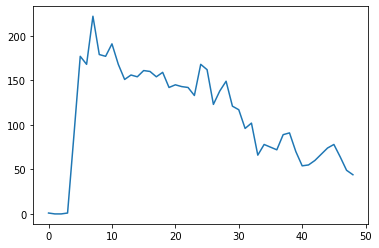

In [110]:
plt.plot(new_dates2)
plt.show()

#### Even though this is not totally stationary, our team expected the data on aircraft dates to decrease over time. This is because the demand for supplies in Haiti decreased as Haiti recovered from the earthquake. The sudden spike is also explained by the large amount of flights that came in to help right after the earthquake struck Haiti. 

### Check for Independence

In [111]:
dates_np = new_dates2['Arrival Count'].values

In [112]:
def turning_points_test(x):
    dx = np.diff(x)
    return np.sum(dx[1:] * dx[:-1] < 0)

In [113]:
turns_dates = turning_points_test(dates_np)
turns_dates

25

#### Mean

In [114]:
Mean_Dates = ((2*len(dates_np))-4) / 3
Mean_Dates

31.333333333333332

#### Standard Deviation

In [115]:
Sigma_Dates = ((16*len(dates_np))-29) / 90
Sigma_Dates

8.38888888888889

#### Test Statistic

In [116]:
test_stat_date = (turns_dates - Mean_Dates) / math.sqrt(Sigma_Dates)
test_stat_date

-2.1866542830640565

### Conclusion

In [117]:
if test_stat_date < stats.norm.ppf(0.025) or test_stat_date > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Reject the null hypothesis that the data is independent


#### The data was considered not independent according to the turning points test. However our team will still treat this data as independent because the test statistic was just outside the interval of critical values. This most likely resulted from real-world factors such as weather, demand, and flight schedules. 

### Fitting a Distribution

In [118]:
get_distributions()

['alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gilbrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgauss',
 'pareto',
 'pearson3',
 'powerlaw',
 'pow

,sumsquare_error,aic,bic,kl_div
gamma,0.061297,842.012330,-61880.790411,inf
norm,0.064324,822.775708,-61627.430223,inf
uniform,0.066938,778.240202,-61411.002362,inf
expon,0.076818,840.695410,-60662.871158,inf
alpha,0.281265,1078.213657,-53601.739846,inf


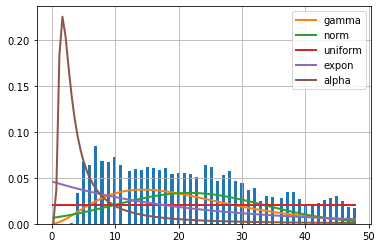

In [119]:
f_date = Fitter(new_dates,
           distributions=["gamma",
                         "expon",
                         "norm",
                         "alpha",
                         "uniform"])
f_date.fit()
f_date.summary()

In [120]:
f_date.get_best(method='sumsquare_error')

{'gamma': {'a': 2.996579249717062,
  'loc': -0.14065366983646216,
  'scale': 7.276766177056913}}

#### Even though the data was discrete, we have fit the following continuous distributions because there were a large amount of observations in the data. Fitting a discrete distribution to a dataset with a large amount of observations may increase the bias in our model. Therefore we used the continuous distributions to lower the bias in our model. The python function, Fitter, identified the gamma distribution with the parameters listed above as the optimal distribution for the aircraft arrival date data. This also makes sense because the gamma distribution is great for arrival times because it can not model time before zero. 

## Analysis of Ground Time Data

### Wide-Body Aircraft

### Continous or Discrete?

In [121]:
ground_time_wide = plane_wide['Ground Time (Hrs)']
ground_time_wide

5       2.722
24      2.476
46      2.303
84      2.220
85      2.869
        ...  
5325    1.943
5407    1.890
5413    3.153
5414    3.401
5415    2.208
Name: Ground Time (Hrs), Length: 387, dtype: float64

In [122]:
ground_time_wide.dtypes

dtype('float64')

#### The data in this lists the ground time for every wide bodied aircraft that landed at Port-au-Prince airport. As seen above python has listed the ground time data as a float object. Further for the ground time data, time is always modeled as a continuous variable. Therefore it is safe to assume that the ground time column will follow a continous distribution. The ground time data for narrow and small body aircraft is also continuous. 

### Check for Homogeneity

In [123]:
grnd_time_wide = plane_wide['Ground Time (Hrs)'].values
grnd_time_wide

array([2.722, 2.476, 2.303, 2.22 , 2.869, 1.995, 1.658, 2.518, 2.876,
       1.882, 3.972, 4.707, 1.509, 1.674, 3.255, 1.797, 2.962, 3.107,
       2.733, 2.224, 2.218, 1.758, 2.444, 2.   , 3.586, 2.422, 2.692,
       2.401, 2.973, 3.015, 4.352, 1.659, 2.72 , 3.556, 3.715, 1.689,
       1.945, 2.593, 2.34 , 1.249, 3.473, 1.842, 1.506, 2.157, 2.298,
       2.634, 2.558, 1.756, 1.519, 2.149, 2.309, 1.674, 2.544, 2.285,
       3.029, 3.518, 3.204, 1.823, 2.058, 3.549, 4.432, 3.141, 2.426,
       3.115, 2.274, 2.449, 1.35 , 2.004, 2.902, 2.499, 1.414, 3.241,
       2.453, 2.383, 2.137, 3.447, 2.477, 2.423, 3.614, 3.686, 2.638,
       4.074, 2.52 , 2.832, 3.207, 2.988, 4.274, 1.958, 3.596, 3.619,
       3.427, 2.233, 2.565, 2.786, 3.002, 2.759, 3.333, 2.942, 2.789,
       2.101, 2.844, 3.074, 3.283, 3.077, 2.89 , 2.876, 3.707, 2.805,
       3.381, 1.815, 3.394, 3.216, 3.224, 3.776, 3.219, 1.804, 1.727,
       1.514, 3.437, 3.364, 2.338, 1.904, 2.231, 2.501, 3.661, 3.072,
       1.598, 1.796,

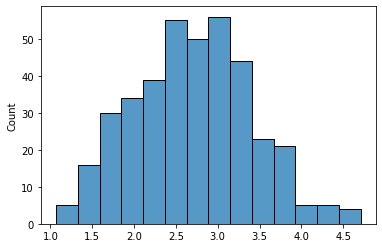

In [124]:
sns.histplot(grnd_time_wide)
plt.show()

#### The data is homogenous because it all follows one distinct distribution

### Check for Stationarity

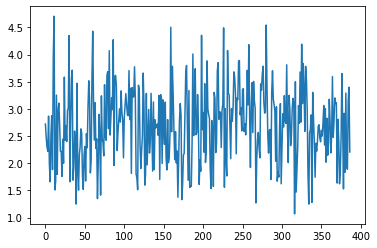

In [125]:
plt.plot(grnd_time_wide)
plt.show()

#### Within the plot above the data does not really trend with time. Meaning it follows a similar pattern throughout the whole plot. Also the data shows a relatively constant variance throughout the plot. There are a quite a few spikes in the data, but they don't seem to occur in any sort of pattern. So these instances can be modeled as outliers in the dataset. Therefore the data for ground time for each aircraft at Port-au-Prince airport is stationary. 

### Check for Independence using a Turning Points Test

In [126]:
turns = turning_points_test(grnd_time_wide)
turns

234

#### Mean 

In [127]:
Mean_R = ((2*len(grnd_time_wide))-4) / 3
Mean_R

256.6666666666667

#### Standard Deviation

In [128]:
Sigma_R2 = ((16*len(grnd_time_wide))-29) / 90
Sigma_R2

68.47777777777777

#### Test Statistic

In [129]:
test_stat = (turns - Mean_R) / math.sqrt(Sigma_R2)
test_stat

-2.739131162650811

#### H_O : The data is independent 
#### H_A : The data is not independent

In [130]:
if test_stat < stats.norm.ppf(0.025) or test_stat > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Reject the null hypothesis that the data is independent


#### In the turning points test we rejected the null hypothesis, meaning the test concluded that the data is not independent. However for small and narrow bodied aircraft the turning points test indicated that the data is independent. A possible reason for this result is that wide body aircraft take longer to off-load than narrow and small body aircraft. 

### Fitting a Distribution

In [131]:
get_distributions()

['alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gilbrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgauss',
 'pareto',
 'pearson3',
 'powerlaw',
 'pow

,sumsquare_error,aic,bic,kl_div
weibull_min,1.897320,345.231209,-2040.183874,inf
norm,1.899710,349.237015,-2045.655091,inf
beta,1.924939,345.414054,-2028.632597,inf
lognorm,1.942908,347.080506,-2030.995086,inf
gamma,1.944865,346.833395,-2030.605649,inf


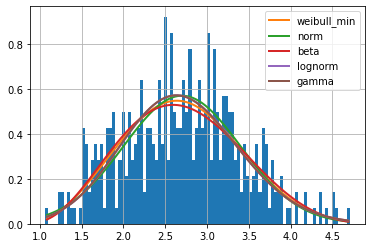

In [132]:
f = Fitter(grnd_time_wide,
           distributions=['gamma',
                          'lognorm',
                          'norm',
                          'beta',
                          'weibull_min'])
f.fit()
f.summary()

In [133]:
f.fitted_param['lognorm']

(0.06232230723027491, -8.507081567581055, 11.18637416518046)

#### According to fitter the best distribution to model the ground time data is the weibull_min distribution. However that is not a very interpretable distribution. Another distribution that had a very low sum of squared error is the log-normal distribution. The log-normal distribution also can only model positive values. Which is great because ground time should not have any negative values. Therefore the ground time data can be modeled with a mean of -8.5071 hours, a standard deviation of 11.1864 hours, and the last parameter of 0.0623 hours. 

### Narrow Body Aircraft

### Check for Homogeneity

In [134]:
grnd_time_narrow = plane_narrow['Ground Time (Hrs)'].values
grnd_time_narrow

array([1.872, 1.454, 1.178, ..., 1.668, 1.237, 1.703])

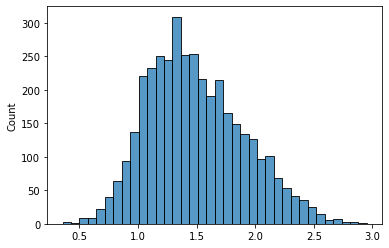

In [135]:
sns.histplot(grnd_time_narrow)
plt.show()

#### The data is homogenous because it all follows one distinct distribution

### Check for Stationarity

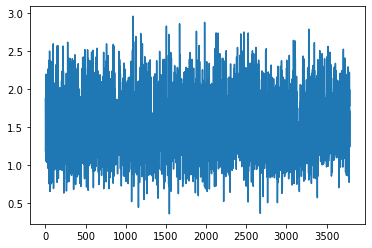

In [136]:
plt.plot(grnd_time_narrow)
plt.show()

#### Within the plot above the data does not really trend with time. Meaning it follows a similar pattern throughout the whole plot. Also the data shows a relatively constant variance throughout the plot. There are a quite a few spikes in the data, but they don't seem to occur in any sort of pattern. So these instances can be modeled as outliers in the dataset. Therefore the data for ground time for each aircraft at Port-au-Prince airport is stationary. 

### Check for Independence

In [137]:
turns2 = turning_points_test(grnd_time_narrow)
turns2

2511

#### Mean

In [138]:
Mean_R2 = ((2*len(grnd_time_narrow))-4) / 3
Mean_R2

2525.3333333333335

#### Standard Deviation

In [139]:
Sigma_R22 = ((16*len(grnd_time_narrow))-29) / 90
Sigma_R22

673.4555555555555

#### Test Statistic

In [140]:
test_stat2 = (turns2 - Mean_R2) / math.sqrt(Sigma_R22)
test_stat2

-0.552322494199532

#### Conclusion

In [141]:
if test_stat2 < stats.norm.ppf(0.025) or test_stat2 > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Fail to reject the null hypothesis that the data is independent


#### In the turning points test we failed to reject the null hypothesis, meaning that we concluded the data is independent.

### Fitting a Distribution

,sumsquare_error,aic,bic,kl_div
gamma,0.504459,362.410846,-33798.721399,inf
lognorm,0.515800,358.009618,-33714.457850,inf
beta,0.523099,371.517423,-33652.957243,inf
weibull_min,0.965688,363.670531,-31337.665015,inf
norm,1.253670,358.448883,-30356.753574,inf


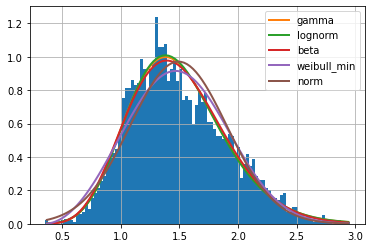

In [142]:
f2 = Fitter(grnd_time_narrow,
           distributions=['gamma',
                          'lognorm',
                          'norm',
                          'beta',
                          'weibull_min'])
f2.fit()
f2.summary()

In [143]:
f2.get_best(method = 'sumsquare_error')

{'gamma': {'a': 13.889743429003904,
  'loc': -0.0437804076303738,
  'scale': 0.11053998207885424}}

#### The gamma distribution was identified as the best distribution for this dataset. Also it can only model positive values like the log-normal distribution. Which is great because ground time should not have any negative values. The gamma distribution is also great for modeling time inbetween events, and the ground time data is the time between landing and taking off. Therefore the ground time data for narrow aircraft can be modeled with a mean of -0.0438 hours, a standard deviation of 0.1105 hours, and the last parameter of 13.8897 hours. 

### Small Body Aircraft

### Check for Homogeneity

In [144]:
grnd_time_small = plane_small['Ground Time (Hrs)'].values
grnd_time_small

array([0.748, 1.265, 1.208, ..., 1.181, 1.292, 0.771])

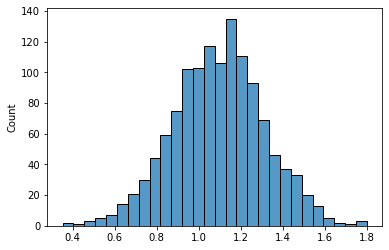

In [145]:
sns.histplot(grnd_time_small)
plt.show()

#### The data is homogenous because it all follows one distinct distribution

### Check for Stationarity

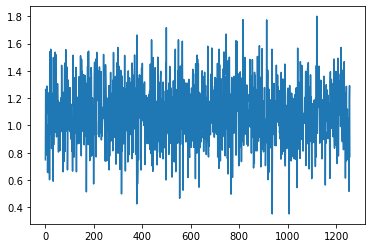

In [146]:
plt.plot(grnd_time_small)
plt.show()

#### Within the plot above the data does not really trend with time. Meaning it follows a similar pattern throughout the whole plot. Also the data shows a relatively constant variance throughout the plot. There are a quite a few spikes in the data, but they don't seem to occur in any sort of pattern. So these instances can be modeled as outliers in the dataset. Therefore the data for ground time for each aircraft at Port-au-Prince airport is stationary. 

### Check for Independence

In [147]:
turns3 = turning_points_test(grnd_time_small)
turns3

851

#### Mean

In [148]:
Mean_R3 = ((2*len(grnd_time_small))-4) / 3
Mean_R3

836.6666666666666

#### Standard Deviation

In [149]:
Sigma_R23 = ((16*len(grnd_time_small))-29) / 90
Sigma_R23

223.14444444444445

#### Test Stat

In [150]:
test_stat3 = (turns3 - Mean_R3) / math.sqrt(Sigma_R23)
test_stat3

0.9595202871212294

#### Conclusion

In [151]:
if test_stat3 < stats.norm.ppf(0.025) or test_stat3 > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Fail to reject the null hypothesis that the data is independent


#### In the turning points test we failed to reject the null hypothesis, meaning that we concluded the data is independent.


### Fitting a Distribution

,sumsquare_error,aic,bic,kl_div
beta,3.525823,256.629794,-7358.050217,inf
norm,3.533383,253.264899,-7369.630755,inf
lognorm,3.544063,255.729519,-7358.700671,inf
gamma,3.560433,256.343285,-7352.908038,inf
weibull_min,3.893747,263.167920,-7240.419364,inf


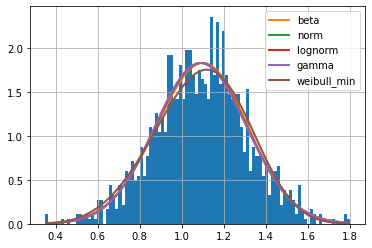

In [152]:
f3 = Fitter(grnd_time_small,
           distributions=['gamma',
                          'lognorm',
                          'norm',
                          'beta',
                          'weibull_min'])
f3.fit()
f3.summary()

In [153]:
f3.fitted_param['gamma']

(2473.4470779115754, -9.734305966619512, 0.00437755831023072)

#### The gamma distribution will also work great for this dataset. Also it can only model positive values like the log-normal distribution. Which is great because ground time should not have any negative values. The gamma distribution is also great for modeling time inbetween events, and the ground time data is the time between landing and taking off. Therefore the ground time data for small aircraft can be modeled with a mean of -9.7343 hours, a standard deviation of 0.0044 hours, and the last parameter of 2473.4471 hours. 